In [ ]:
import numpy as np
import kagglehub
import pandas as pd
import os
import torch
import matplotlib.pyplot as plt
import sklearn
from torch import nn, optim, utils, device
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import GroupShuffleSplit, train_test_split
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.integrate import cumulative_trapezoid
from scipy.spatial.transform import Rotation as R
pd.set_option("display.max_columns", None)
pd.set_option("display.width", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

c:\Users\320166460\AppData\Local\Programs\Python\Python313\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser(".kaggle")

In [ ]:
path = kagglehub.competition_download('cmi-detect-behavior-with-sensor-data')

In [ ]:
train_df = pd.read_csv(os.path.join(path, 'train.csv'))

In [ ]:
print(f"📊 Dataset loaded successfully!")
print(f"   - Total frames: {train_df.shape[0]:,}")
print(f"   - Total features: {train_df.shape[1]}")
print(f"   - Unique sequences: {train_df['sequence_id'].nunique():,}")
print(f"   - Unique subjects: {train_df['subject'].nunique()}")
print(f"   - Gesture classes: {train_df['gesture'].nunique()}")

# Display first few rows
train_df.head()

📊 Dataset loaded successfully!
   - Total frames: 574,945
   - Total features: 341
   - Unique sequences: 8,151
   - Unique subjects: 81
   - Gesture classes: 18


📊 Dataset loaded successfully!
   - Total frames: 574,945
   - Total features: 341
   - Unique sequences: 8,151
   - Unique subjects: 81
   - Gesture classes: 18


,row_id,sequence_type,sequence_id,sequence_counter,subject,orientation,behavior,phase,gesture,acc_x,acc_y,acc_z,rot_w,rot_x,rot_y,rot_z,thm_1,thm_2,thm_3,thm_4,thm_5,tof_1_v0,tof_1_v1,tof_1_v2,tof_1_v3,tof_1_v4,tof_1_v5,tof_1_v6,tof_1_v7,tof_1_v8,tof_1_v9,tof_1_v10,tof_1_v11,tof_1_v12,tof_1_v13,tof_1_v14,tof_1_v15,tof_1_v16,tof_1_v17,tof_1_v18,tof_1_v19,tof_1_v20,tof_1_v21,tof_1_v22,tof_1_v23,tof_1_v24,tof_1_v25,tof_1_v26,tof_1_v27,tof_1_v28,tof_1_v29,tof_1_v30,tof_1_v31,tof_1_v32,tof_1_v33,tof_1_v34,tof_1_v35,tof_1_v36,tof_1_v37,tof_1_v38,tof_1_v39,tof_1_v40,tof_1_v41,tof_1_v42,tof_1_v43,tof_1_v44,tof_1_v45,tof_1_v46,tof_1_v47,tof_1_v48,tof_1_v49,tof_1_v50,tof_1_v51,tof_1_v52,tof_1_v53,tof_1_v54,tof_1_v55,tof_1_v56,tof_1_v57,tof_1_v58,tof_1_v59,tof_1_v60,tof_1_v61,tof_1_v62,tof_1_v63,tof_2_v0,tof_2_v1,tof_2_v2,tof_2_v3,tof_2_v4,tof_2_v5,tof_2_v6,tof_2_v7,tof_2_v8,tof_2_v9,tof_2_v10,tof_2_v11,tof_2_v12,tof_2_v13,tof_2_v14,tof_2_v15,tof_2_v16,tof_2_v17,tof_2_v18,tof_2_v19,tof_2_v20,tof_2_v21,tof_2_v22,tof_2_v23,tof_2_v24,tof_2_v25,tof_2_v26,tof_2_v27,tof_2_v28,tof_2_v29,tof_2_v30,tof_2_v31,tof_2_v32,tof_2_v33,tof_2_v34,tof_2_v35,tof_2_v36,tof_2_v37,tof_2_v38,tof_2_v39,tof_2_v40,tof_2_v41,tof_2_v42,tof_2_v43,tof_2_v44,tof_2_v45,tof_2_v46,tof_2_v47,tof_2_v48,tof_2_v49,tof_2_v50,tof_2_v51,tof_2_v52,tof_2_v53,tof_2_v54,tof_2_v55,tof_2_v56,tof_2_v57,tof_2_v58,tof_2_v59,tof_2_v60,tof_2_v61,tof_2_v62,tof_2_v63,tof_3_v0,tof_3_v1,tof_3_v2,tof_3_v3,tof_3_v4,tof_3_v5,tof_3_v6,tof_3_v7,tof_3_v8,tof_3_v9,tof_3_v10,tof_3_v11,tof_3_v12,tof_3_v13,tof_3_v14,tof_3_v15,tof_3_v16,tof_3_v17,tof_3_v18,tof_3_v19,tof_3_v20,tof_3_v21,tof_3_v22,tof_3_v23,tof_3_v24,tof_3_v25,tof_3_v26,tof_3_v27,tof_3_v28,tof_3_v29,tof_3_v30,tof_3_v31,tof_3_v32,tof_3_v33,tof_3_v34,tof_3_v35,tof_3_v36,tof_3_v37,tof_3_v38,tof_3_v39,tof_3_v40,tof_3_v41,tof_3_v42,tof_3_v43,tof_3_v44,tof_3_v45,tof_3_v46,tof_3_v47,tof_3_v48,tof_3_v49,tof_3_v50,tof_3_v51,tof_3_v52,tof_3_v53,tof_3_v54,tof_3_v55,tof_3_v56,tof_3_v57,tof_3_v58,tof_3_v59,tof_3_v60,tof_3_v61,tof_3_v62,tof_3_v63,tof_4_v0,tof_4_v1,tof_4_v2,tof_4_v3,tof_4_v4,tof_4_v5,tof_4_v6,tof_4_v7,tof_4_v8,tof_4_v9,tof_4_v10,tof_4_v11,tof_4_v12,tof_4_v13,tof_4_v14,tof_4_v15,tof_4_v16,tof_4_v17,tof_4_v18,tof_4_v19,tof_4_v20,tof_4_v21,tof_4_v22,tof_4_v23,tof_4_v24,tof_4_v25,tof_4_v26,tof_4_v27,tof_4_v28,tof_4_v29,tof_4_v30,tof_4_v31,tof_4_v32,tof_4_v33,tof_4_v34,tof_4_v35,tof_4_v36,tof_4_v37,tof_4_v38,tof_4_v39,tof_4_v40,tof_4_v41,tof_4_v42,tof_4_v43,tof_4_v44,tof_4_v45,tof_4_v46,tof_4_v47,tof_4_v48,tof_4_v49,tof_4_v50,tof_4_v51,tof_4_v52,tof_4_v53,tof_4_v54,tof_4_v55,tof_4_v56,tof_4_v57,tof_4_v58,tof_4_v59,tof_4_v60,tof_4_v61,tof_4_v62,tof_4_v63,tof_5_v0,tof_5_v1,tof_5_v2,tof_5_v3,tof_5_v4,tof_5_v5,tof_5_v6,tof_5_v7,tof_5_v8,tof_5_v9,tof_5_v10,tof_5_v11,tof_5_v12,tof_5_v13,tof_5_v14,tof_5_v15,tof_5_v16,tof_5_v17,tof_5_v18,tof_5_v19,tof_5_v20,tof_5_v21,tof_5_v22,tof_5_v23,tof_5_v24,tof_5_v25,tof_5_v26,tof_5_v27,tof_5_v28,tof_5_v29,tof_5_v30,tof_5_v31,tof_5_v32,tof_5_v33,tof_5_v34,tof_5_v35,tof_5_v36,tof_5_v37,tof_5_v38,tof_5_v39,tof_5_v40,tof_5_v41,tof_5_v42,tof_5_v43,tof_5_v44,tof_5_v45,tof_5_v46,tof_5_v47,tof_5_v48,tof_5_v49,tof_5_v50,tof_5_v51,tof_5_v52,tof_5_v53,tof_5_v54,tof_5_v55,tof_5_v56,tof_5_v57,tof_5_v58,tof_5_v59,tof_5_v60,tof_5_v61,tof_5_v62,tof_5_v63
0,SEQ_000007_000000,Target,SEQ_000007,0,SUBJ_059520,Seated Lean Non Dom - FACE DOWN,Relaxes and moves hand to target location,Transition,Cheek - pinch skin,6.683594,6.214844,3.355469,0.134399,-0.355164,-0.447327,-0.809753,28.943842,31.822186,29.553024,28.592863,28.310535,131.0,134.0,132.0,135.0,98.0,74.0,64.0,60.0,-1.0,-1.0,152.0,153.0,141.0,89.0,68.0,63.0,-1.0,-1.0,-1.0,-1.0,169.0,118.0,86.0,73.0,-1.0,-1.0,-1.0,-1.0,-1.0,147.0,110.0,87.0,126.0,-1.0,-1.0,-1.0,-1.0,-1.0,137.0,108.0,115.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,128.0,110.0,129.0,140.0,-1.0,126.0,131.0,-1.0,-1.0,-1.0,108.0,122.0,139.0,113.0,121.0,-1.0,118.0,96.0,-1.0,-1.0,-1.0,-1.0,165.0,124.0,100.0,102.0,119.0,-1.0,-1.0,

In [ ]:
train_df.groupby(['gesture', 'sequence_id']).count()["row_id"]

gesture                                     sequence_id
Above ear - pull hair                       SEQ_000091      61
                                            SEQ_000092      54
                                            SEQ_000169      81
                                            SEQ_000281      55
                                            SEQ_000320      57
                                            SEQ_000323      83
                                            SEQ_000449      47
                                            SEQ_000475      49
                                            SEQ_000517      81
                                            SEQ_000617      94
                                            SEQ_000626      79
                                            SEQ_000793      50
                                            SEQ_000942      55
                                            SEQ_000949      56
                                            SEQ_000976     102

In [ ]:
BFRB_GESTURES = [
    'Above ear - Pull hair',
    'Forehead - Pull hairline',
    'Forehead - Scratch',
    'Eyebrow - Pull hair',
    'Eyelash - Pull hair',
    'Neck - Pinch skin',
    'Neck - Scratch',
    'Cheek - Pinch skin' # Note: Ensure this matches your train_df exactly
]
train_df['is_bfrb'] = train_df['gesture'].isin(BFRB_GESTURES)
# 1. Initialize the encoder
le = LabelEncoder()

# 2. Extract the first gesture label from each unique sequence to avoid redundancy
sequence_labels = train_df.groupby('sequence_id')['gesture'].first()

# 3. Fit the encoder and transform
# This creates the 'gesture_encoded' column your Dataset class expects
le.fit(sequence_labels)

# 4. Map it back to the main dataframe
gesture_map = dict(zip(sequence_labels.index, le.transform(sequence_labels)))
train_df['gesture_encoded'] = train_df['sequence_id'].map(gesture_map)
train_df.info(), train_df.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 574945 entries, 0 to 574944
Columns: 343 entries, row_id to gesture_encoded
dtypes: bool(1), float64(332), int64(2), object(8)
memory usage: 1.5+ GB


(None,
 Index(['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject',
        'orientation', 'behavior', 'phase', 'gesture', 'acc_x',
        ...
        'tof_5_v56', 'tof_5_v57', 'tof_5_v58', 'tof_5_v59', 'tof_5_v60',
        'tof_5_v61', 'tof_5_v62', 'tof_5_v63', 'is_bfrb', 'gesture_encoded'],
       dtype='object', length=343))

#Train Test Split

In [ ]:
def final_robust_split(df, subject_col='subject', bfrb_col='is_bfrb', test_size=0.15, val_size=0.15):
    # 1. Map subjects to whether they mostly performed BFRB or Non-BFRB
    # This is a broader category, so it's guaranteed to have enough members to split.
    sub_logic = df.groupby(subject_col)[bfrb_col].mean().reset_index()
    sub_logic['broad_cat'] = (sub_logic[bfrb_col] > 0.5).astype(int)

    # 2. Shuffle subjects
    unique_subs = sub_logic.sample(frac=1, random_state=42)

    # 3. Use simple percentages to slice the unique subjects
    n_total = len(unique_subs)
    n_test = int(n_total * test_size)
    n_val = int(n_total * val_size)

    test_subs = unique_subs.iloc[:n_test][subject_col]
    val_subs = unique_subs.iloc[n_test:n_test+n_val][subject_col]
    train_subs = unique_subs.iloc[n_test+n_val:][subject_col]

    # 4. Create the final dataframes
    train_set = df[df[subject_col].isin(train_subs)]
    val_set = df[df[subject_col].isin(val_subs)]
    test_set = df[df[subject_col].isin(test_subs)]

    return train_set, val_set, test_set

# Pre-requisite: ensure 'is_bfrb' exists as you defined in your EDA
train_set, val_set, test_set = final_robust_split(train_df)
train_set = train_set.reset_index(drop=True)
val_set = val_set.reset_index(drop=True)
test_set = test_set.reset_index(drop=True)

In [ ]:
print(train_set.info(), len(train_set), train_set.columns, train_set.head(), sep=f"\n{"*"*80}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 406777 entries, 0 to 406776
Columns: 343 entries, row_id to gesture_encoded
dtypes: bool(1), float64(332), int64(2), object(8)
memory usage: 1.0+ GB
None
********************************************************************************
406777
********************************************************************************
Index(['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject',
       'orientation', 'behavior', 'phase', 'gesture', 'acc_x',
       ...
       'tof_5_v56', 'tof_5_v57', 'tof_5_v58', 'tof_5_v59', 'tof_5_v60',
       'tof_5_v61', 'tof_5_v62', 'tof_5_v63', 'is_bfrb', 'gesture_encoded'],
      dtype='object', length=343)
********************************************************************************
              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000013_000000        Target  SEQ_000013                 0  SUBJ_040282   
1  SEQ_000013_000001        Target  SEQ_000013 

In [ ]:
print(val_set.info(), len(val_set), val_set.columns, val_set.head(), sep=f"\n{"*"*80}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79383 entries, 0 to 79382
Columns: 343 entries, row_id to gesture_encoded
dtypes: bool(1), float64(332), int64(2), object(8)
memory usage: 207.2+ MB
None
********************************************************************************
79383
********************************************************************************
Index(['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject',
       'orientation', 'behavior', 'phase', 'gesture', 'acc_x',
       ...
       'tof_5_v56', 'tof_5_v57', 'tof_5_v58', 'tof_5_v59', 'tof_5_v60',
       'tof_5_v61', 'tof_5_v62', 'tof_5_v63', 'is_bfrb', 'gesture_encoded'],
      dtype='object', length=343)
********************************************************************************
              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000007_000000        Target  SEQ_000007                 0  SUBJ_059520   
1  SEQ_000007_000001        Target  SEQ_000007  

In [ ]:
print(test_set.info(), len(test_set), test_set.columns, test_set.head(), sep=f"\n{"*"*80}\n")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88785 entries, 0 to 88784
Columns: 343 entries, row_id to gesture_encoded
dtypes: bool(1), float64(332), int64(2), object(8)
memory usage: 231.7+ MB
None
********************************************************************************
88785
********************************************************************************
Index(['row_id', 'sequence_type', 'sequence_id', 'sequence_counter', 'subject',
       'orientation', 'behavior', 'phase', 'gesture', 'acc_x',
       ...
       'tof_5_v56', 'tof_5_v57', 'tof_5_v58', 'tof_5_v59', 'tof_5_v60',
       'tof_5_v61', 'tof_5_v62', 'tof_5_v63', 'is_bfrb', 'gesture_encoded'],
      dtype='object', length=343)
********************************************************************************
              row_id sequence_type sequence_id  sequence_counter      subject  \
0  SEQ_000008_000000        Target  SEQ_000008                 0  SUBJ_020948   
1  SEQ_000008_000001        Target  SEQ_000008  

# Train Test Split Validation Graphs

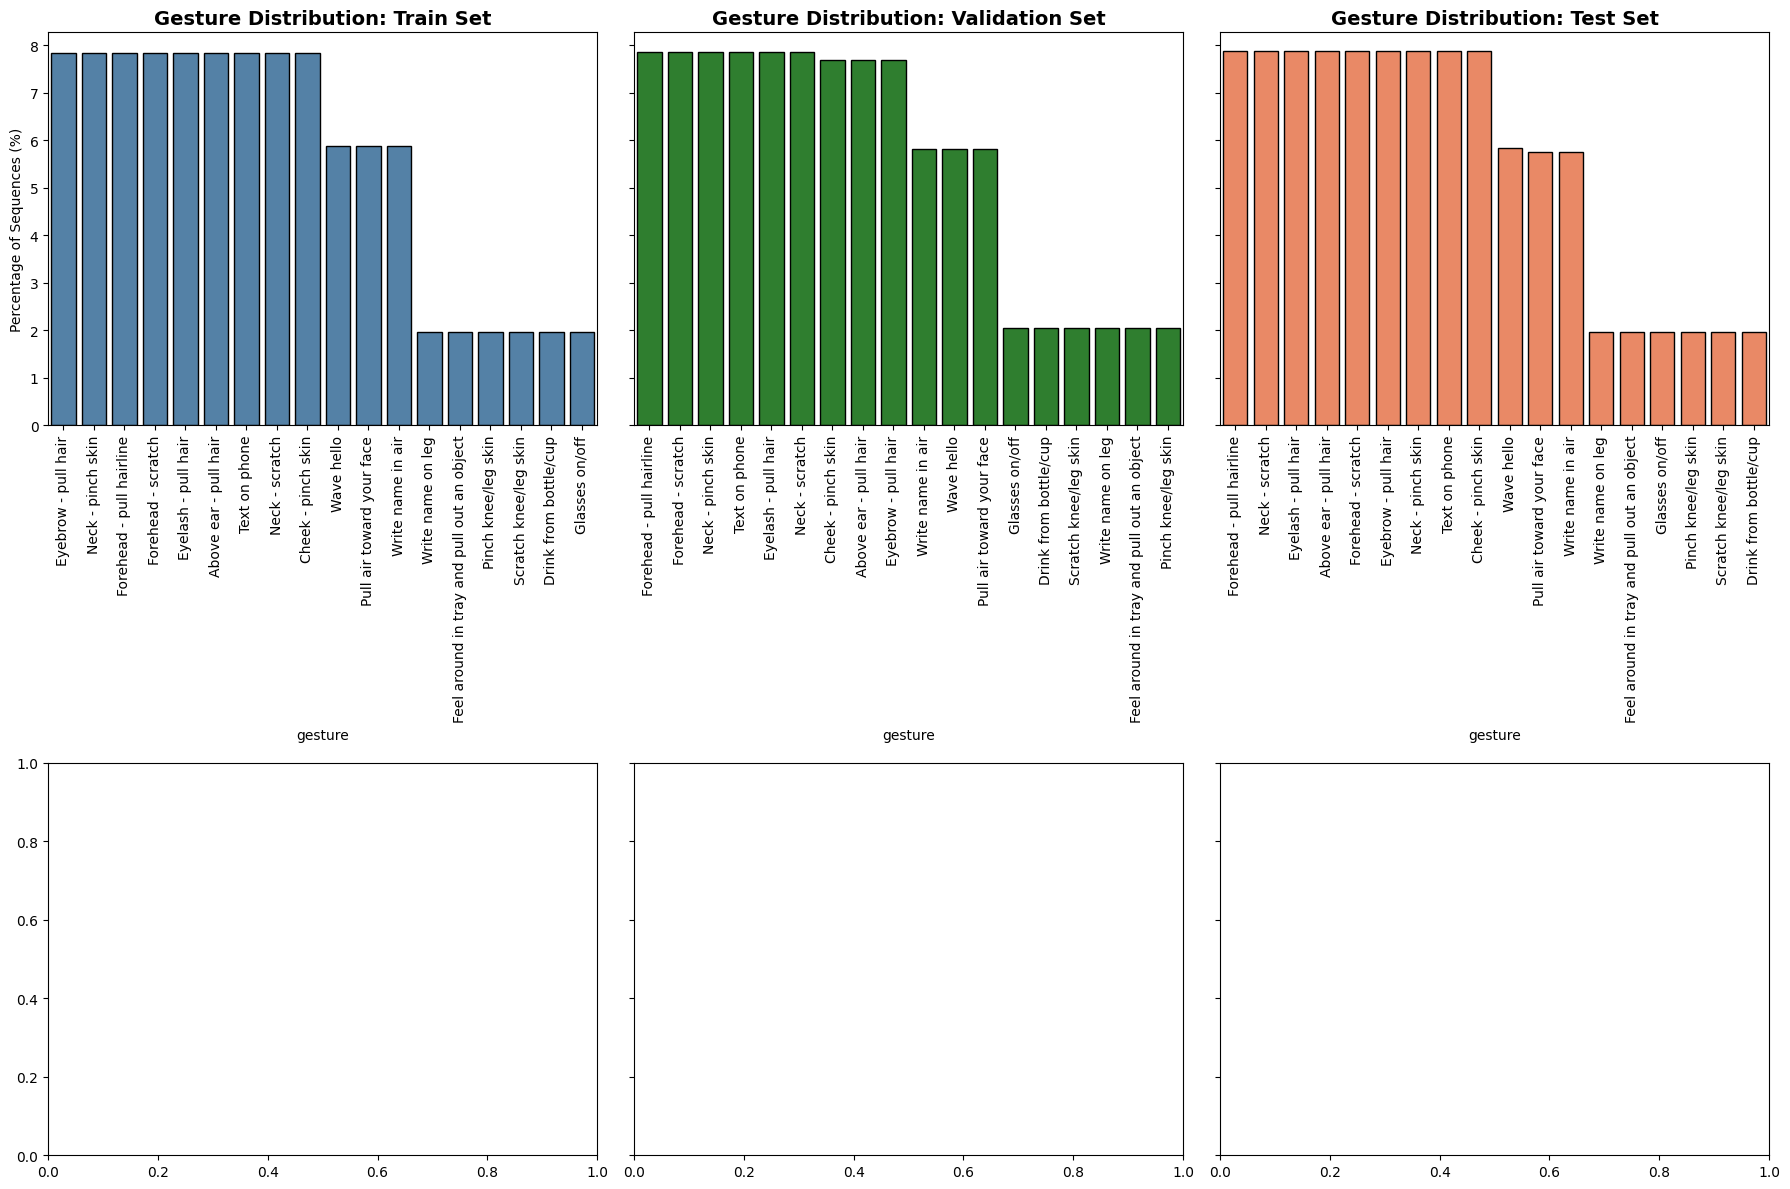

In [ ]:
def plot_dataset_distributions(train, val, test):
    fig, axes = plt.subplots(2, 3, figsize=(18, 12), sharey='row')
    datasets = [train, val, test]
    names = ['Train Set', 'Validation Set', 'Test Set']
    colors = ['steelblue', 'forestgreen', 'coral']

    for i, (df, name) in enumerate(zip(datasets, names)):
        # 1. Gesture Distribution (Normalized to %)
        gesture_dist = df.groupby('sequence_id')['gesture'].first().value_counts(normalize=True) * 100
        sns.barplot(x=gesture_dist.index, y=gesture_dist.values, ax=axes[0, i], color=colors[i], edgecolor='black')
        axes[0, i].set_title(f'Gesture Distribution: {name}', fontsize=14, fontweight='bold')
        axes[0, i].tick_params(axis='x', rotation=90)
        axes[0, i].set_ylabel('Percentage of Sequences (%)' if i == 0 else "")
    plt.tight_layout()
    plt.show()

# Run the visualization
plot_dataset_distributions(train_set, val_set, test_set)

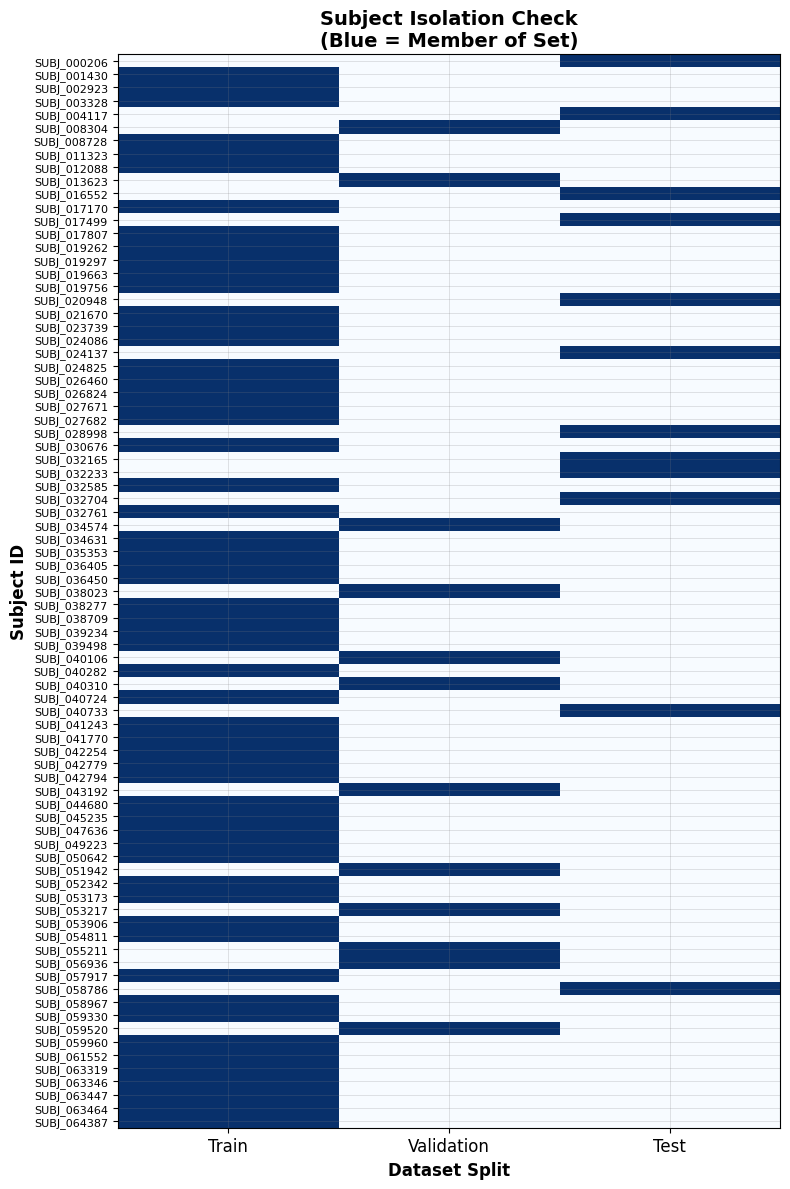

In [ ]:
def plot_subject_membership(train, val, test):
    # Get unique subjects from each set
    train_subs = sorted(train['subject'].unique())
    val_subs = sorted(val['subject'].unique())
    test_subs = sorted(test['subject'].unique())

    # Combine all unique subjects to create a master list
    all_subs = sorted(list(set(train_subs) | set(val_subs) | set(test_subs)))
    sub_to_idx = {sub: i for i, sub in enumerate(all_subs)}

    # Initialize the matrix (Subjects x Sets)
    matrix = np.zeros((len(all_subs), 3))

    # Fill the matrix
    for sub in train_subs: matrix[sub_to_idx[sub], 0] = 1
    for sub in val_subs:   matrix[sub_to_idx[sub], 1] = 1
    for sub in test_subs:  matrix[sub_to_idx[sub], 2] = 1

    # Create the Plot
    plt.figure(figsize=(8, 12))
    plt.imshow(matrix, aspect='auto', cmap='Blues', interpolation='nearest')

    # Formatting
    plt.xticks([0, 1, 2], ['Train', 'Validation', 'Test'], fontsize=12)
    plt.yticks(range(len(all_subs)), all_subs, fontsize=8)
    plt.xlabel('Dataset Split', fontsize=12, fontweight='bold')
    plt.ylabel('Subject ID', fontsize=12, fontweight='bold')
    plt.title('Subject Isolation Check\n(Blue = Member of Set)', fontsize=14, fontweight='bold')

    # Add a grid to make it easier to see row-wise isolation
    plt.grid(which='both', color='gray', linestyle='-', linewidth=0.5, alpha=0.3)

    plt.tight_layout()
    plt.show()

# Run the visualization
plot_subject_membership(train_set, val_set, test_set)

1. Architectural Strategy
According to the best practices for this specific sensor suite:
- IMU (Acc/Rot): Best handled by 1D-CNNs or GRUs to capture temporal movement intensity and direction.
- ToF (320-pixel grid): Since this is a spatial $24\times24$ or $16\times16$ grid, a 2D-CNN (Spatial Encoder) is ideal for capturing hand position relative to the sensor.
- Thermal (thm): Simple MLP paths work well for these 5 continuous numerical values.
2. Handling Missing Modalities
Since 50% of the evaluation data is IMU-only, we use a Late Fusion approach. If ToF or Rotation data is missing (all -1s or NaNs), we zero out their specific feature vectors before the final classification layer.

In [ ]:
class MinMaxNormalize(nn.Module):
    """Custom layer to scale inputs to [0, 1] based on provided or observed bounds."""
    def __init__(self, min_val, max_val):
        super(MinMaxNormalize, self).__init__()
        self.min_val = min_val
        self.max_val = max_val

    def forward(self, x):
        # Clamp to ensure values outside training bounds don't break the [0, 1] range
        x = torch.clamp(x, self.min_val, self.max_val)
        return (x - self.min_val) / (self.max_val - self.min_val + 1e-6)

class HeliosMultimodalNet(nn.Module):
    def __init__(self, num_classes=18):
        super(HeliosMultimodalNet, self).__init__()

        # 1. Accelerometer Path (Input range: approx -20 to 20 m/s^2) [cite: 1131, 1199]
        self.acc_path = nn.Sequential(
            MinMaxNormalize(-20.0, 20.0),
            nn.Conv1d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        # 2. Rotation Path (Quaternions are natively -1 to 1) [cite: 120, 1232]
        self.rot_path = nn.Sequential(
            MinMaxNormalize(-1.0, 1.0),
            nn.Conv1d(4, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.AdaptiveAvgPool1d(1),
            nn.Flatten()
        )

        # 3. ToF Path (Range: 0 to 249 mm)
        # We handle the -1 (missing) values separately in the forward pass
        self.tof_path = nn.Sequential(
            MinMaxNormalize(0.0, 249.0),
            nn.Linear(320, 256),
            nn.ReLU(),
            nn.Unflatten(1, (1, 16, 16)), # 16x16 indented frame [cite: 776]
            nn.Conv2d(1, 16, kernel_size=3),
            nn.ReLU(),
            nn.Flatten()
        )

        # 4. Thermal Path (Standard body/room temp range: 20 to 45°C) [cite: 121, 139]
        self.thm_path = nn.Sequential(
            MinMaxNormalize(20.0, 45.0),
            nn.Linear(5, 16),
            nn.ReLU()
        )

        # Final Fusion
        self.fc_fusion = nn.Linear(3216, 128)
        self.classifier = nn.Linear(128, num_classes)

    def forward(self, acc, rot, tof, thm):
        # Initial data cleaning for ToF [cite: 437]
        if tof is not None:
            # Replace -1 (out of range) with the max distance (249) before normalization
            tof = torch.where(tof == -1, torch.tensor(249.0).to(tof.device), tof)

        x_acc = self.acc_path(acc)

        # Handling Missing Rotation Data
        x_rot = self.rot_path(rot) if rot is not None else torch.zeros(x_acc.size(0), 32).to(acc.device)

        # Handling Missing ToF Data [cite: 275, 433]
        x_tof = self.tof_path(tof) if tof is not None else torch.zeros(x_acc.size(0), 3136).to(acc.device)

        x_thm = self.thm_path(thm)

        combined = torch.cat((x_acc, x_rot, x_tof, x_thm), dim=1)
        x = F.relu(self.fc_fusion(combined))
        return self.classifier(x)


In [ ]:
class HeliosInertialNet(nn.Module):
    def __init__(self, num_classes=18):
        super(HeliosInertialNet, self).__init__()

        # Enhanced multi-scale temporal feature extraction
        # Input shape: (Batch, 3, Sequence_Length)

        # 1. First Conv Block - Capture fine temporal patterns
        self.conv1 = nn.Sequential(
            MinMaxNormalize(-20.0, 20.0),
            nn.Conv1d(3, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # 2. Second Conv Block - Deeper features
        self.conv2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # 3. Third Conv Block - High-level features
        self.conv3 = nn.Sequential(
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.2)
        )

        # 4. Bidirectional LSTM for sequential dependencies
        self.lstm = nn.LSTM(
            input_size=256,
            hidden_size=128,
            num_layers=2,
            batch_first=True,
            dropout=0.2,
            bidirectional=True
        )

        # 5. Global pooling - both average and max for richer representation
        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.global_max_pool = nn.AdaptiveMaxPool1d(1)

        # 6. Classification Head with deeper FC layers
        self.fc = nn.Sequential(
            nn.Linear(512, 256),  # 256 from LSTM (128*2 bidirectional) + skip connections
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, num_classes)
        )

    def forward(self, acc):
        # acc shape: (batch_size, 3, sequence_length)

        # Convolutional feature extraction
        x = self.conv1(acc)
        x = self.conv2(x)
        x = self.conv3(x)

        # Prepare for LSTM: (batch, channels, seq) -> (batch, seq, channels)
        x = x.permute(0, 2, 1)

        # LSTM processing
        x, _ = self.lstm(x)

        # Back to (batch, channels, seq) for pooling
        x = x.permute(0, 2, 1)

        # Dual pooling for richer features
        x_avg = self.global_avg_pool(x).squeeze(-1)
        x_max = self.global_max_pool(x).squeeze(-1)

        # Combine pooled features
        x = torch.cat([x_avg, x_max], dim=1)

        # Classification
        return self.fc(x)

In [ ]:
model = HeliosInertialNet(num_classes=18)
print(f"Model initialized with {sum(p.numel() for p in model.parameters()):,} parameters")
model

Model initialized with 1,099,026 parameters


HeliosInertialNet(
  (conv1): Sequential(
    (0): MinMaxNormalize()
    (1): Conv1d(3, 64, kernel_size=(7,), stride=(1,), padding=(3,))
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): ReLU()
    (4): Dropout(p=0.2, inplace=False)
  )
  (conv2): Sequential(
    (0): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (conv3): Sequential(
    (0): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
  )
  (lstm): LSTM(256, 128, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (global_avg_pool): AdaptiveAvgPool1d(output_size=1)
  (global_max_pool): AdaptiveMaxPool1d(output_size=1)
  (fc): Sequential(
    (0): Lin

In [ ]:
class HeliosDataset(Dataset):
    def __init__(self, dataframe):
        self.df = dataframe.reset_index(drop=True)
        # Grouping by sequence_id handles variable lengths (29-700 frames) [cite: 110, 254]
        self.sequences = list(self.df.groupby('sequence_id'))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq_id, data = self.sequences[idx]

        # 1. Accelerometer: 3 channels (x, y, z)
        acc = torch.tensor(data[['acc_x', 'acc_y', 'acc_z']].values, dtype=torch.float32).T

        # 2. Rotation: 4 channels (x, y, z, w) - Use rot_t_ for quaternions
        # Make sure your column names match the 'rot_t_x' format in the dataset
        rot_cols = [c for c in data.columns if 'rot_' in c]
        rot = torch.tensor(data[rot_cols].values, dtype=torch.float32).T

        # 3. ToF: Handling the 320-pixel grid (5 sensors x 64 pixels) [cite: 256, 661]
        # We take the mean across the sequence to feed the MLP part of the ToF path [cite: 122, 448]
        tof_cols = [c for c in data.columns if 'tof_' in c]
        tof = torch.tensor(data[tof_cols].mean().values, dtype=torch.float32)

        # 4. Thermal: 5 sensors (°C) [cite: 121]
        thm_cols = [c for c in data.columns if 'thm_' in c]
        thm = torch.tensor(data[thm_cols].iloc[0].values, dtype=torch.float32)

        # 5. Label: Ensure 'gesture_encoded' is pre-calculated from the 18 classes [cite: 116, 192]
        label = torch.tensor(data['gesture_encoded'].iloc[0], dtype=torch.long)

        return acc, rot, tof, thm, label # Order now matches model forward pass!

In [ ]:
def helios_collate_fn(batch):
    """Collate function for HeliosInertialNet (accelerometer only)"""
    # 1. Unpack the batch - dataset returns (acc, rot, tof, thm, labels)
    # But we only need acc and labels for HeliosInertialNet
    accs, rots, tofs, thms, labels = zip(*batch)

    # 2. Pad the temporal signals (acc)
    # Permute to (seq_len, channels) for padding, then back to (channels, seq_len)
    acc_padded = pad_sequence([a.T for a in accs], batch_first=True, padding_value=0).transpose(1, 2)

    # 3. Stack labels
    labels_stacked = torch.stack(labels)

    # Return only what HeliosInertialNet needs
    return acc_padded, labels_stacked

In [ ]:
# 1. Loss function
criterion = nn.CrossEntropyLoss()

# 2. Optimizer with higher learning rate and weight decay for regularization
optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# 3. Learning rate scheduler - reduces LR when validation plateaus
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='min',
    factor=0.8,
    patience=10,
)

# 4. DataLoaders with larger batch size for stability
train_ds = HeliosDataset(train_set)
val_ds = HeliosDataset(val_set)
train_loader = DataLoader(
    train_ds,
    batch_size=16,  # Smaller batch for better gradients with LSTM
    shuffle=True,
    collate_fn=helios_collate_fn
)
val_loader = DataLoader(
    val_ds,
    batch_size=16,
    shuffle=False,
    collate_fn=helios_collate_fn
)

In [ ]:
num_epochs = 100
iteration = 0
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Move model to device
model = model.to(device)

# Training metrics storage
history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': [], 'lr': []}

best_val_acc = 0
patience_counter = 0
early_stop_patience = 15

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    epoch_acc = 0
    num_batches = 0

    for batch in train_loader:
        # Unpack batch and move to device
        acc, labels = batch
        acc = acc.to(device)
        labels = labels.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(acc)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()

        # Gradient clipping to prevent exploding gradients in LSTM
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()

        # Track metrics
        batch_acc = (outputs.argmax(1) == labels).float().mean()
        epoch_loss += loss.item()
        epoch_acc += batch_acc.item()
        num_batches += 1
        iteration += 1

    # Calculate average training metrics
    avg_train_loss = epoch_loss / num_batches
    avg_train_acc = epoch_acc / num_batches

    # Validation phase
    model.eval()
    val_loss = 0
    val_acc = 0
    val_batches = 0

    with torch.no_grad():
        for val_batch in val_loader:
            v_acc, v_labels = val_batch
            v_acc = v_acc.to(device)
            v_labels = v_labels.to(device)

            val_outputs = model(v_acc)
            val_loss += criterion(val_outputs, v_labels).item()
            val_acc += (val_outputs.argmax(1) == v_labels).float().mean().item()
            val_batches += 1

    avg_val_loss = val_loss / val_batches
    avg_val_acc = val_acc / val_batches

    # Update learning rate scheduler
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    # Store history
    history['train_loss'].append(avg_train_loss)
    history['train_acc'].append(avg_train_acc * 100)
    history['val_loss'].append(avg_val_loss)
    history['val_acc'].append(avg_val_acc * 100)
    history['lr'].append(current_lr)

    # Early stopping check
    if avg_val_acc > best_val_acc:
        best_val_acc = avg_val_acc
        patience_counter = 0
        # Save best model
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        patience_counter += 1

    # Print every epoch
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"| Train Loss: {avg_train_loss:.4f} Acc: {avg_train_acc*100:.2f}% "
          f"| Val Loss: {avg_val_loss:.4f} Acc: {avg_val_acc*100:.2f}% "
          f"| LR: {current_lr:.6f} | Best Val: {best_val_acc*100:.2f}%")

    # Early stopping
    if patience_counter >= early_stop_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs!")
        break

print(f"\n✅ Training complete! Best validation accuracy: {best_val_acc*100:.2f}%")

Using device: cpu
Epoch [1/100] | Train Loss: 2.6278 Acc: 12.71% | Val Loss: 2.4833 Acc: 15.03% | LR: 0.001000 | Best Val: 15.03%
Epoch [2/100] | Train Loss: 2.4532 Acc: 15.70% | Val Loss: 2.3762 Acc: 17.82% | LR: 0.001000 | Best Val: 17.82%
Epoch [3/100] | Train Loss: 2.2735 Acc: 20.43% | Val Loss: 2.2555 Acc: 19.34% | LR: 0.001000 | Best Val: 19.34%
Epoch [4/100] | Train Loss: 2.0708 Acc: 23.81% | Val Loss: 1.9602 Acc: 25.00% | LR: 0.001000 | Best Val: 25.00%
Epoch [5/100] | Train Loss: 1.9883 Acc: 26.28% | Val Loss: 1.9332 Acc: 28.38% | LR: 0.001000 | Best Val: 28.38%
Epoch [6/100] | Train Loss: 1.9300 Acc: 27.22% | Val Loss: 2.0319 Acc: 29.05% | LR: 0.001000 | Best Val: 29.05%
Epoch [7/100] | Train Loss: 1.8762 Acc: 29.03% | Val Loss: 1.8393 Acc: 31.42% | LR: 0.001000 | Best Val: 31.42%
Epoch [8/100] | Train Loss: 1.8328 Acc: 31.15% | Val Loss: 1.7506 Acc: 34.12% | LR: 0.001000 | Best Val: 34.12%
Epoch [9/100] | Train Loss: 1.7788 Acc: 31.79% | Val Loss: 1.7558 Acc: 30.91% | LR: 0.

In [ ]:
# Save the model to the notebook's directory
notebook_dir = os.path.dirname(os.path.abspath('deep_learning_models_plain_vanilla.ipynb'))
model_path = os.path.join(notebook_dir, 'helios_inertial_model_plain_vanilla.pth')
best_model_path = os.path.join(notebook_dir, 'best_model_plain_vanilla.pth')

# Save current model state
torch.save({
    'epoch': len(history['train_loss']),
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'train_loss': history['train_loss'],
    'train_acc': history['train_acc'],
    'val_loss': history['val_loss'],
    'val_acc': history['val_acc'],
}, model_path)

print(f"✅ Model saved to: {model_path}")
print(f"✅ Best model saved to: {best_model_path}")

# Also save just the model architecture and weights for easy loading
torch.save(model, os.path.join(notebook_dir, 'helios_inertial_model_plain_vanilla.pth'))
print(f"✅ Complete model saved to: {os.path.join(notebook_dir, 'helios_inertial_model_plain_vanilla.pth')}")

✅ Model saved to: c:\Users\320166460\OneDrive - Philips\Documents\study\פתוחה\סדנה במדעי הנתונים 20936\CMI_data_science_workshop_project\sadna\helios_inertial_model_plain_vanilla.pth
✅ Best model saved to: c:\Users\320166460\OneDrive - Philips\Documents\study\פתוחה\סדנה במדעי הנתונים 20936\CMI_data_science_workshop_project\sadna\best_model_plain_vanilla.pth
✅ Complete model saved to: c:\Users\320166460\OneDrive - Philips\Documents\study\פתוחה\סדנה במדעי הנתונים 20936\CMI_data_science_workshop_project\sadna\helios_inertial_model_plain_vanilla.pth


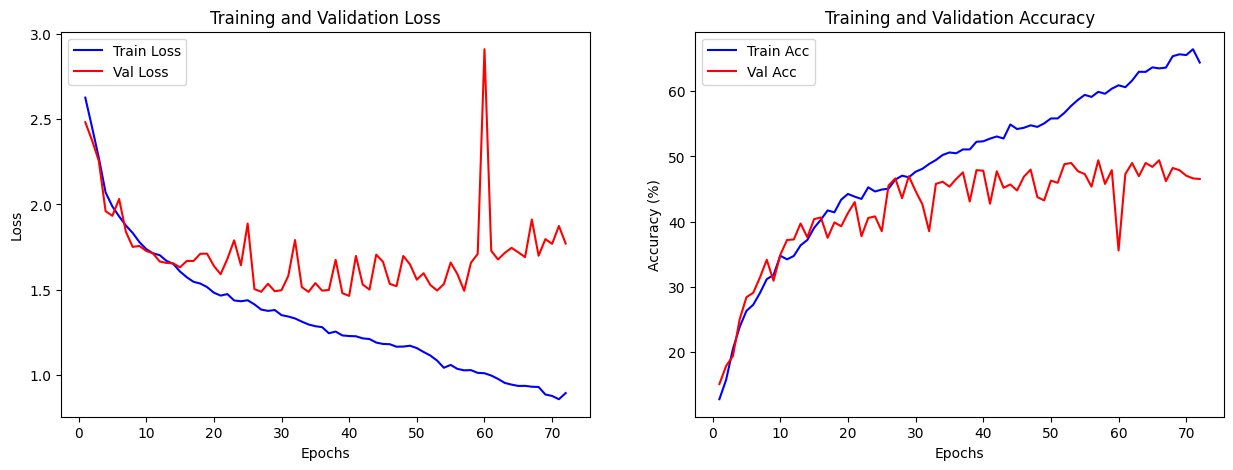

In [ ]:
def plot_results():
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Loss Plot
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy Plot
    ax2.plot(epochs, history['train_acc'], 'b-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'], 'r-', label='Val Acc')
    ax2.set_title('Training and Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy (%)')
    ax2.legend()

    plt.show()

plot_results()

In [ ]:
test_ds = HeliosDataset(test_set)
test_loader = DataLoader(
    test_ds,
    batch_size=16,  # Smaller batch for better gradients with LSTM
    shuffle=True,
    collate_fn=helios_collate_fn
)


📝 Test Set Performance Analysis:
                                            precision    recall  f1-score   support

                     Above ear - pull hair       0.46      0.46      0.46        96
                        Cheek - pinch skin       0.24      0.33      0.28        96
                     Drink from bottle/cup       1.00      0.75      0.86        24
                       Eyebrow - pull hair       0.25      0.20      0.22        96
                       Eyelash - pull hair       0.27      0.55      0.37        96
Feel around in tray and pull out an object       0.73      0.79      0.76        24
                  Forehead - pull hairline       0.30      0.19      0.23        96
                        Forehead - scratch       0.42      0.38      0.40        96
                            Glasses on/off       0.71      1.00      0.83        24
                         Neck - pinch skin       0.27      0.30      0.29        96
                            Neck - scratc

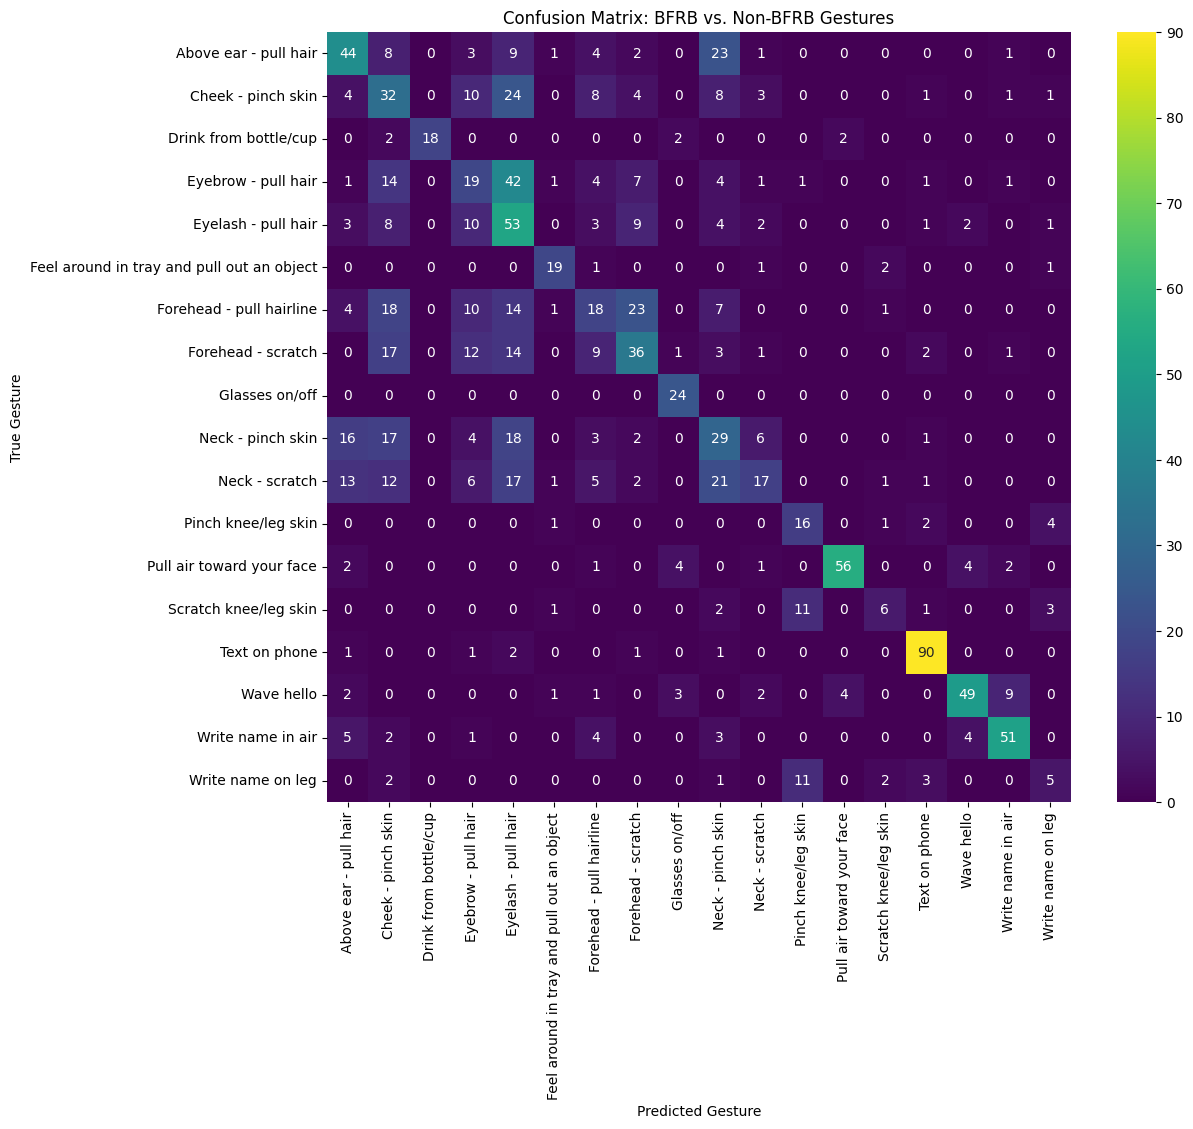

In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Setup
#model_path = 'best_model.pth'
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Re-instantiate your specific model architecture
# model = HeliosLSTM(...)
model.to(device)

# 3. Robust Loading
#checkpoint = torch.load(model_path, map_location=device)
#if isinstance(checkpoint, dict) and 'model_state_dict' in checkpoint:
#   model.load_state_dict(checkpoint['model_state_dict'])
#else:
#    model.load_state_dict(checkpoint)
model.eval()

# 4. Evaluation Loop (Fixed for 2-item unpack)
all_preds = []
all_labels = []
all_outputs = []  # To store raw outputs for potential further analysis

with torch.no_grad():
    for sequences, labels in test_loader: # Fixed: Expecting 2 values
        sequences, labels = sequences.to(device), labels.to(device)

        # If your model requires lengths, you'll need to calculate them here
        # or update your collate_fn. For now, we assume model(sequences) works:
        outputs = model(sequences)
        all_outputs.extend(outputs.cpu().numpy())  # Store raw outputs for later analysis

        _, predicted = torch.max(outputs.data, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# 5. The Story: Interpretation and Visualization
target_names = le.classes_
print("\n📝 Test Set Performance Analysis:")
print(classification_report(all_labels, all_preds, target_names=target_names))

plt.figure(figsize=(12, 10))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names, cmap='viridis')
plt.title("Confusion Matrix: BFRB vs. Non-BFRB Gestures")
plt.ylabel('True Gesture')
plt.xlabel('Predicted Gesture')
plt.show()

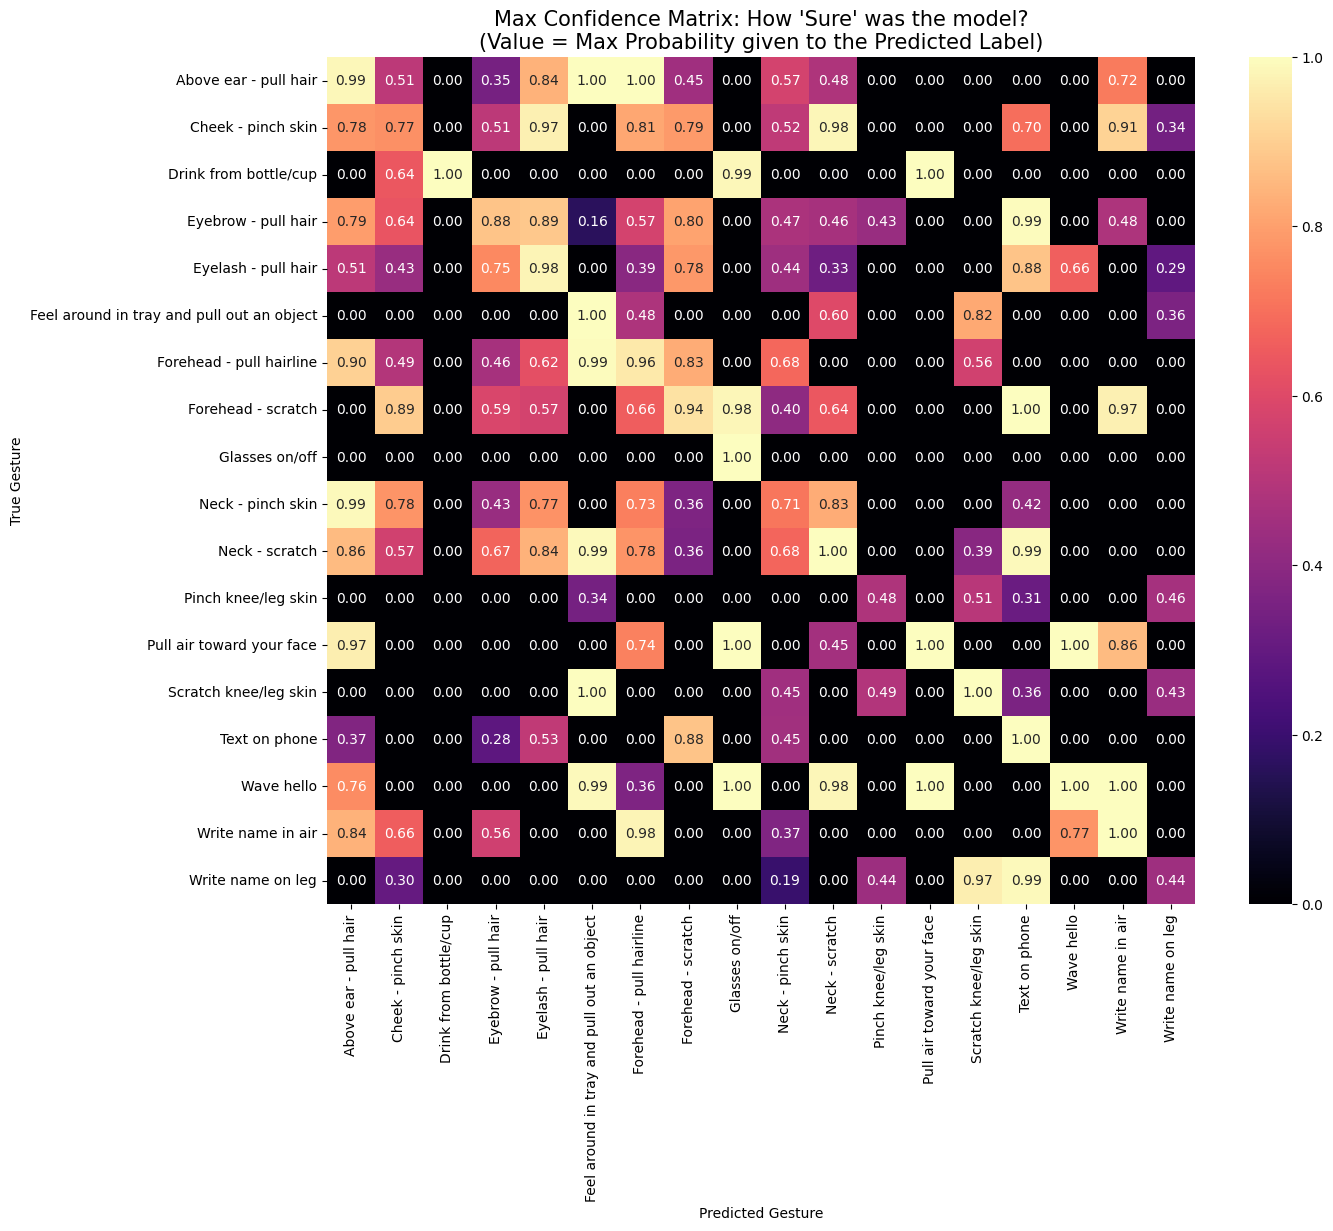

In [ ]:
import torch.nn.functional as F
import numpy as np

# 1. Get Probabilities
# Ensure all_outputs is a tensor
outputs_tensor = torch.tensor(np.array(all_outputs))
probs = F.softmax(outputs_tensor, dim=1).numpy()

# 2. Initialize a Matrix for Max Confidences
# Shape: (num_classes, num_classes)
num_classes = len(target_names)
conf_matrix_max = np.zeros((num_classes, num_classes))

# 3. Fill the matrix with the maximum confidence found for each pair
for i in range(len(all_labels)):
    true_idx = all_labels[i]
    pred_idx = all_preds[i]
    confidence = probs[i, pred_idx]

    # Only keep the highest confidence seen for this specific (True, Pred) pair
    if confidence > conf_matrix_max[true_idx, pred_idx]:
        conf_matrix_max[true_idx, pred_idx] = confidence

# 4. Visualization
plt.figure(figsize=(14, 11))
sns.heatmap(
    conf_matrix_max,
    annot=True,
    fmt='.2f',
    xticklabels=target_names,
    yticklabels=target_names,
    cmap='magma'
)

plt.title("Max Confidence Matrix: How 'Sure' was the model?\n(Value = Max Probability given to the Predicted Label)", fontsize=15)
plt.ylabel('True Gesture')
plt.xlabel('Predicted Gesture')
plt.show()

In [ ]:
len(set(pd.Series(val_set["sequence_id"].unique())).union(pd.Series(train_set["sequence_id"].unique())))

6932

In [ ]:
len(val_set["sequence_id"].unique()) + len(train_set["sequence_id"].unique())

6932

In [ ]:
len(set(pd.Series(test_set["sequence_id"].unique())).union(pd.Series(train_set["sequence_id"].unique())))

6981

In [ ]:
len(test_set["sequence_id"].unique()) + len(train_set["sequence_id"].unique())

6981

In [ ]:
len(set(pd.Series(val_set["sequence_id"].unique())).union(pd.Series(test_set["sequence_id"].unique())))

2389

In [ ]:
len(val_set["sequence_id"].unique()) + len(test_set["sequence_id"].unique())

2389

In [ ]:
def visualize_activations(model, input_tensor, layer_idx, label_encoder):
    """
    model: The gesture recognition model
    input_tensor: A single sequence [1, channels, length]
    layer_idx: Index of the convolutional layer to visualize
    label_encoder: The sklearn LabelEncoder used during training
    """
    # Use a forward hook to get the layer output
    activations = []
    def hook(module, input, output):
        activations.append(output)

    handle = list(model.children())[layer_idx].register_forward_hook(hook)

    # Run forward pass
    model.eval()
    with torch.no_grad():
        # Get the logits from the model output
        logits = model(input_tensor)

        # Determine the predicted class index and name
        pred_idx = torch.argmax(logits, dim=1).item()
        pred_label = label_encoder.inverse_transform([pred_idx])[0]

    handle.remove()

    # Plot the first few filters
    act = activations[0].squeeze().cpu().numpy()

    plt.figure(figsize=(15, 6))
    for i in range(min(5, act.shape[0])): # Plot first 5 filters
        plt.plot(act[i], label=f'Filter {i}', alpha=0.8)

    # Add the predicted label to the title to help tell the story
    plt.title(f"Activations for Layer {layer_idx}\nPredicted Gesture: {pred_label}",
              fontsize=14, fontweight='bold', color='darkblue')

    plt.xlabel("Time Steps")
    plt.ylabel("Activation Strength")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

    return pred_label

# Usage:
# predicted_gesture = visualize_activations(model, sample_input, 0, le)

In [ ]:
gesture = val_set['gesture'].value_counts().index[0]
print(gesture)
sample_seqs = val_set[val_set['gesture'] == gesture].drop_duplicates('sequence_id')['sequence_id'].values[:10]


Text on phone


In [ ]:
input_sequence = torch.tensor(val_set[val_set["sequence_id"] == val_set["sequence_id"].unique()[0]][[
    "acc_x", "acc_y", "acc_z"
]].to_numpy(), dtype=torch.float32).T.unsqueeze(0).to(device)  # Shape: [1, 3, seq_len]

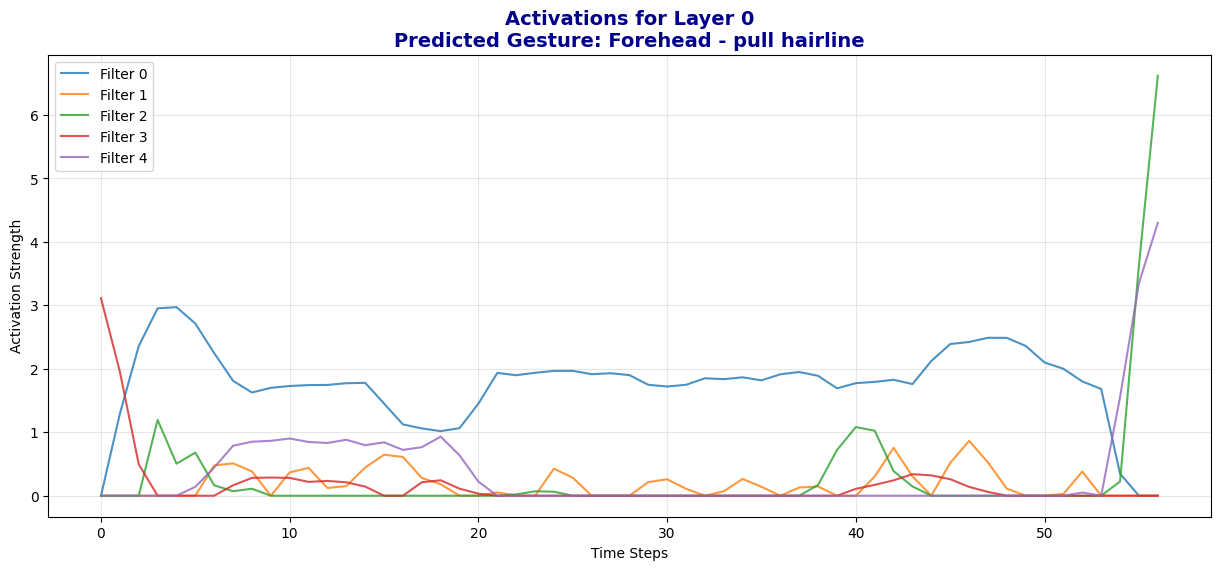

'Forehead - pull hairline'

In [ ]:
visualize_activations(model, input_sequence, layer_idx=0, label_encoder=le)

In [ ]:
input_sequence = torch.tensor(val_set[val_set["sequence_id"] == val_set["sequence_id"].unique()[1]][[
    "acc_x", "acc_y", "acc_z"
]].to_numpy(), dtype=torch.float32).T.unsqueeze(0).to(device)  # Shape: [1, 3, seq_len]

(64, 78)


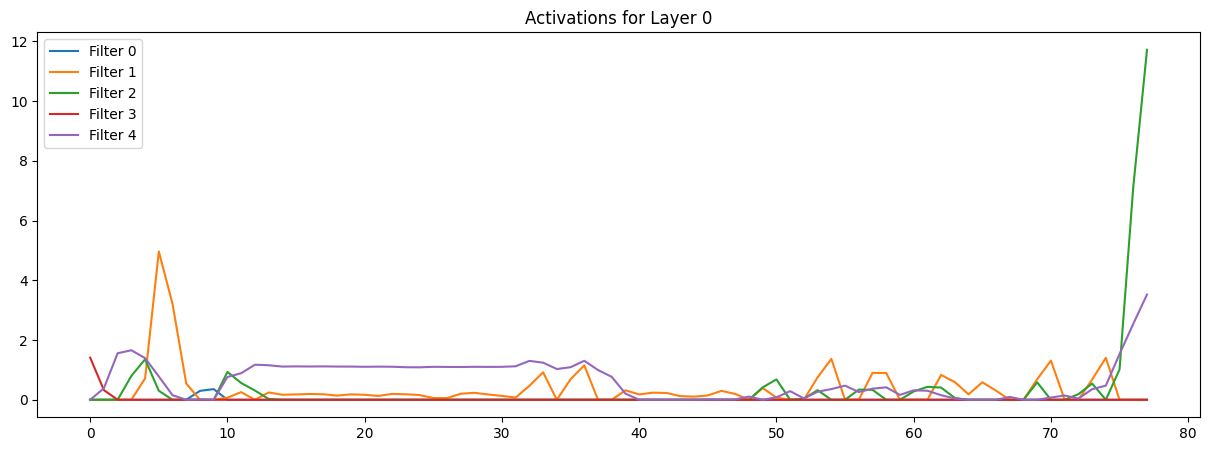

In [ ]:
visualize_activations(model, input_sequence, layer_idx=0)

Text on phone

📊 Visualization for Sequence 1/10 (ID: SEQ_000504)


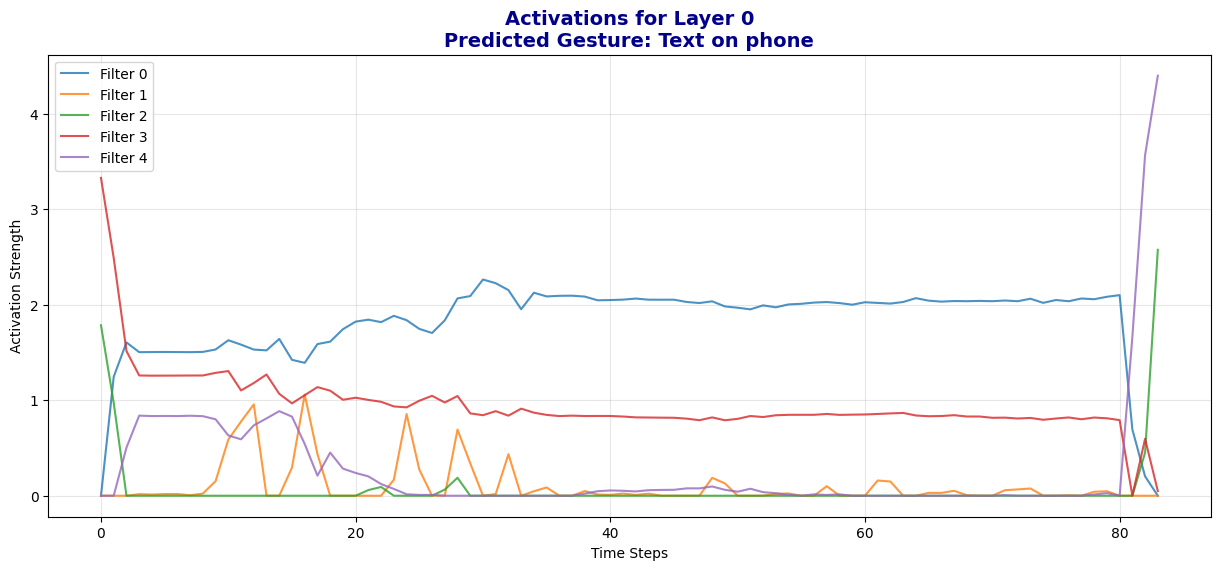


📊 Visualization for Sequence 2/10 (ID: SEQ_001704)


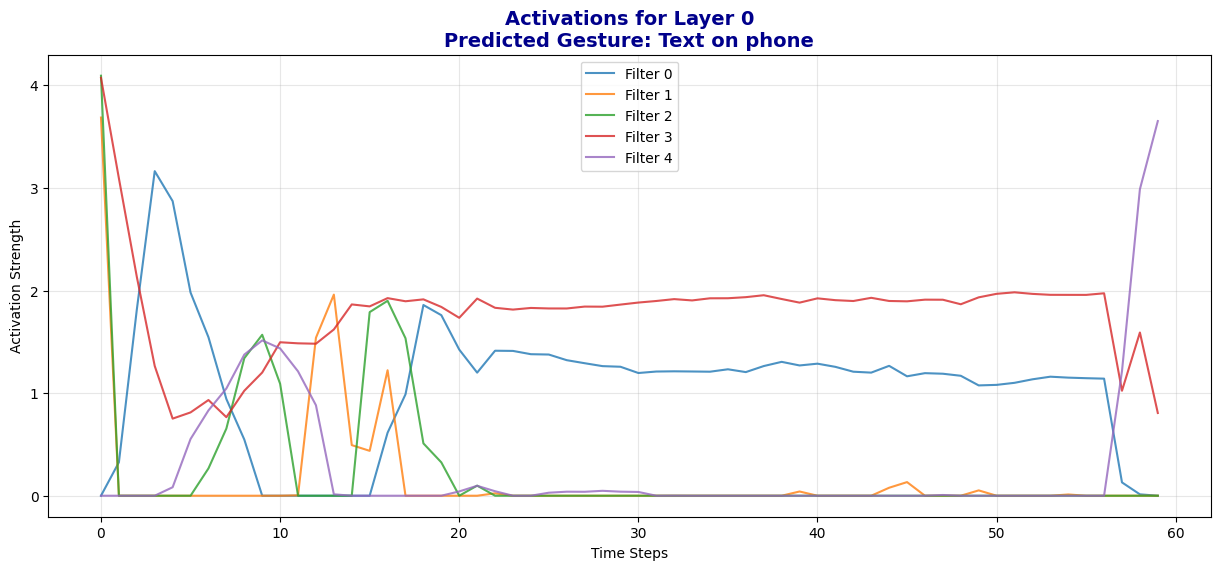


📊 Visualization for Sequence 3/10 (ID: SEQ_002555)


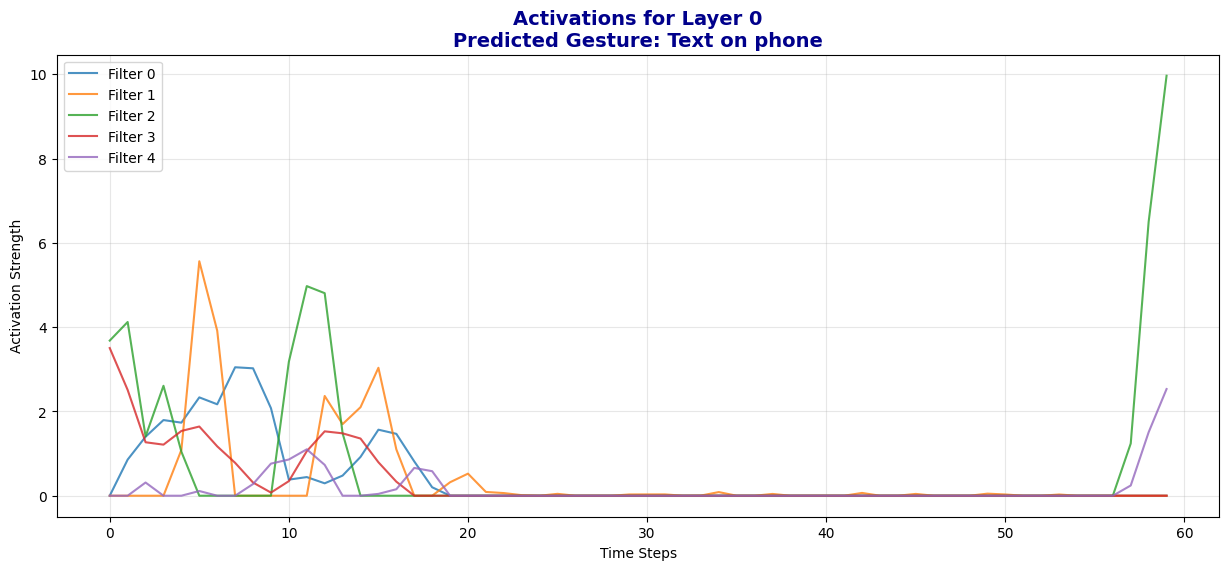


📊 Visualization for Sequence 4/10 (ID: SEQ_004993)


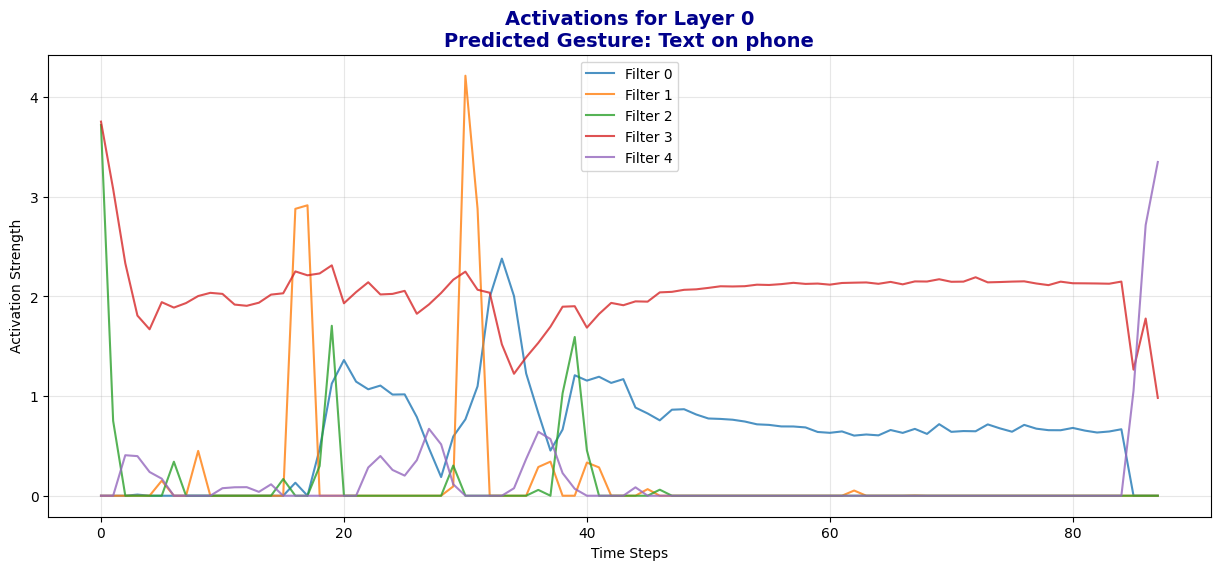


📊 Visualization for Sequence 5/10 (ID: SEQ_006090)


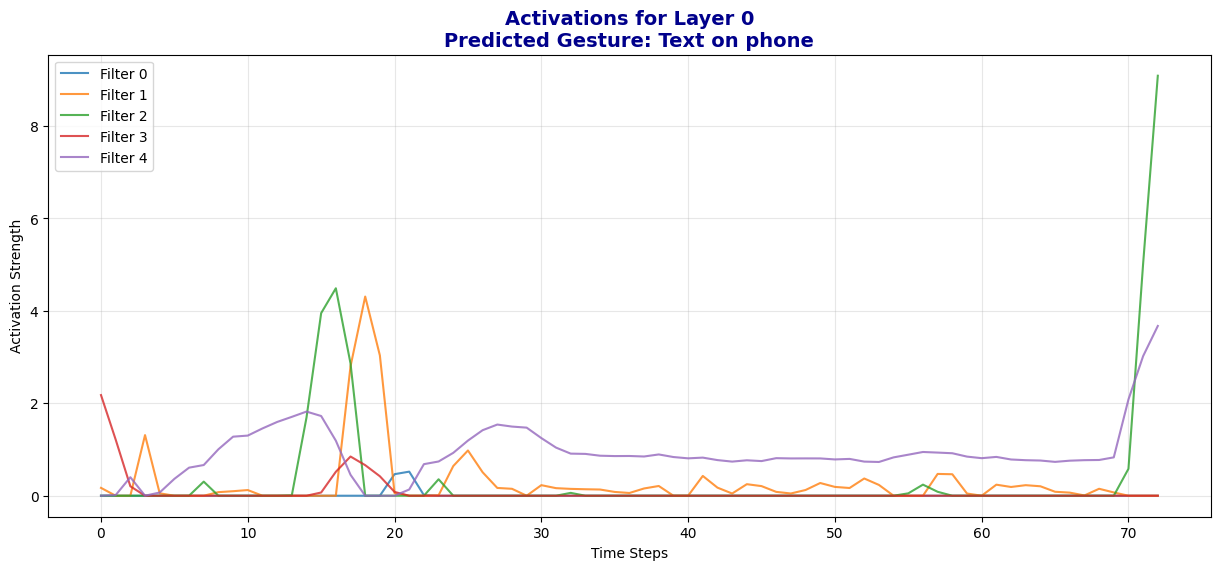


📊 Visualization for Sequence 6/10 (ID: SEQ_006241)


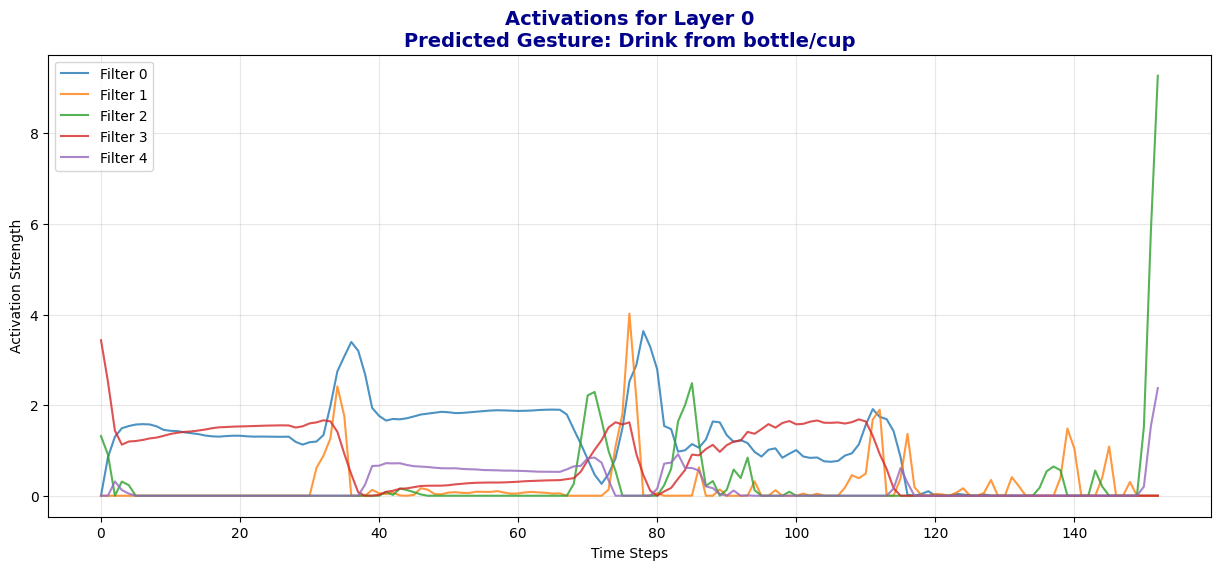


📊 Visualization for Sequence 7/10 (ID: SEQ_007009)


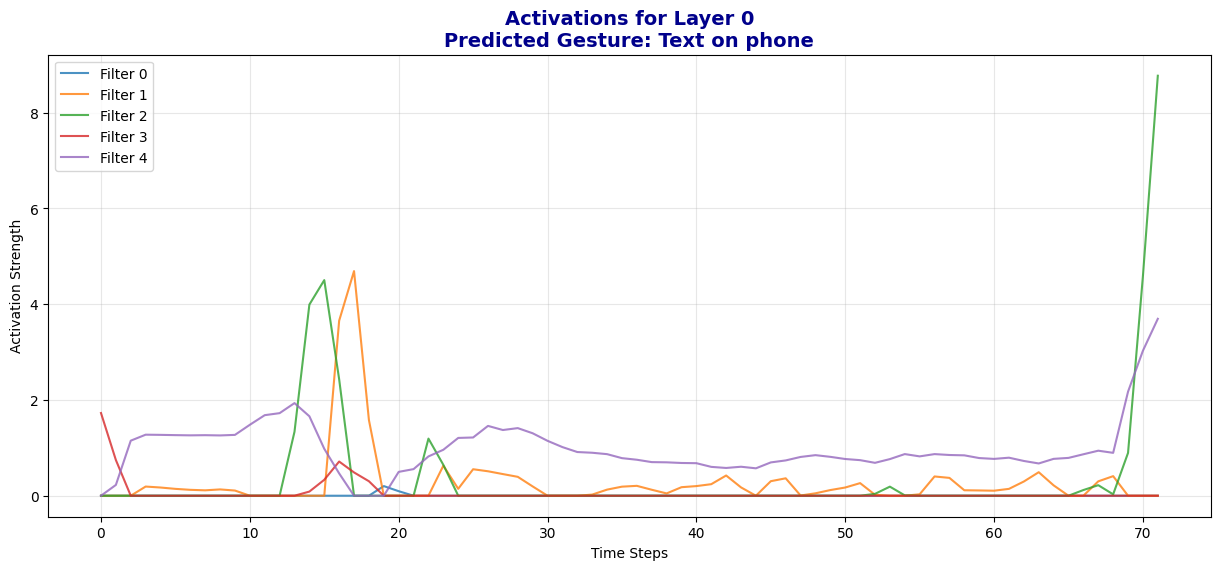


📊 Visualization for Sequence 8/10 (ID: SEQ_008980)


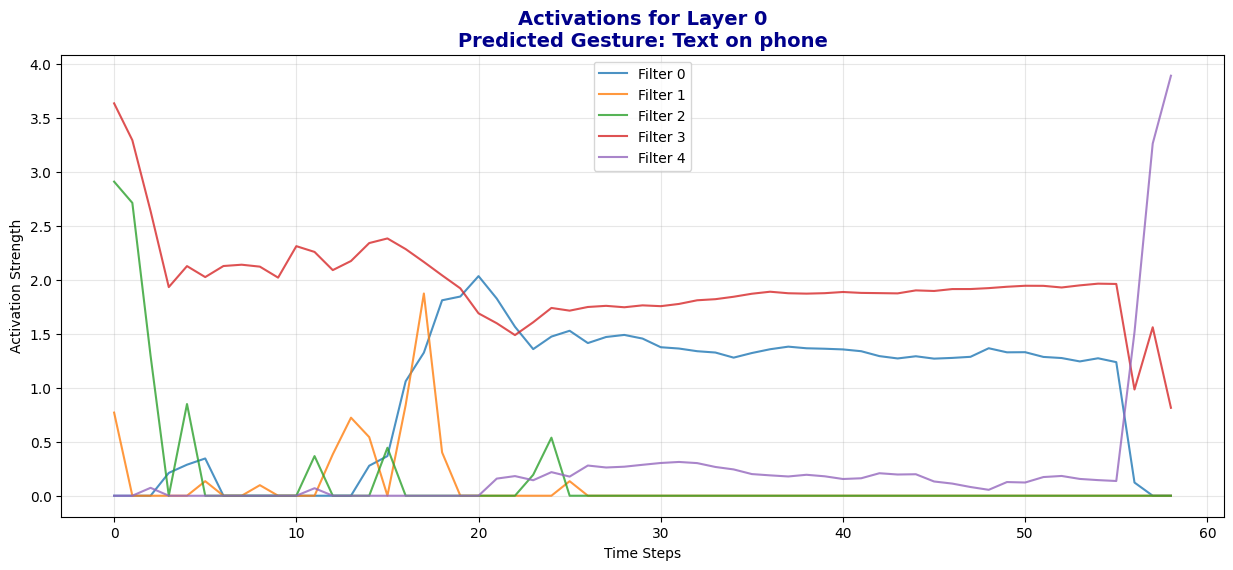


📊 Visualization for Sequence 9/10 (ID: SEQ_009523)


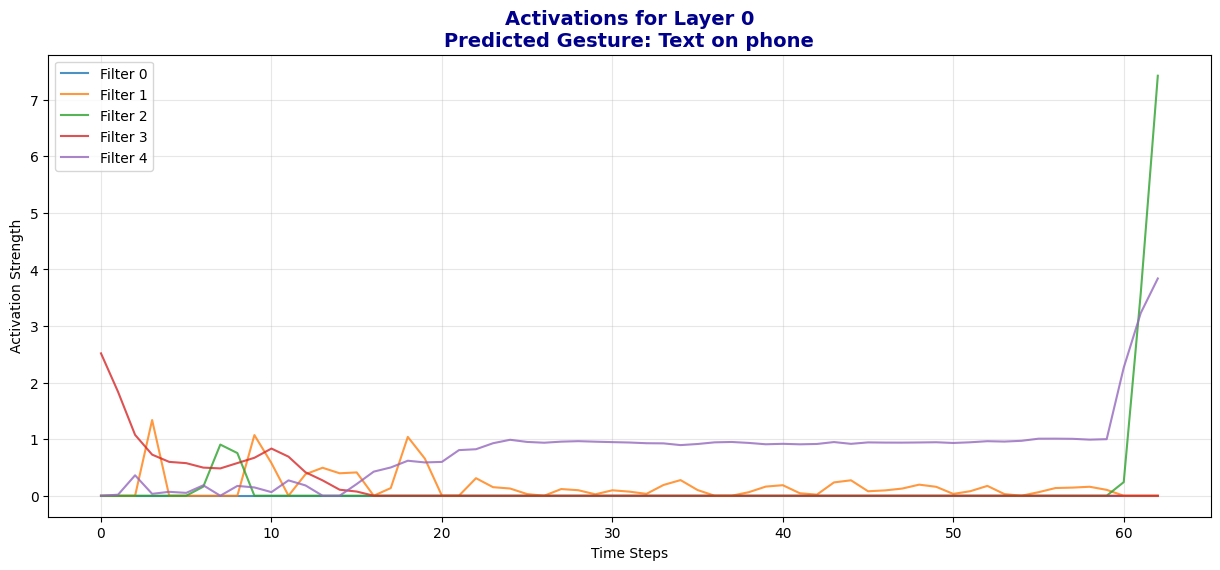


📊 Visualization for Sequence 10/10 (ID: SEQ_009839)


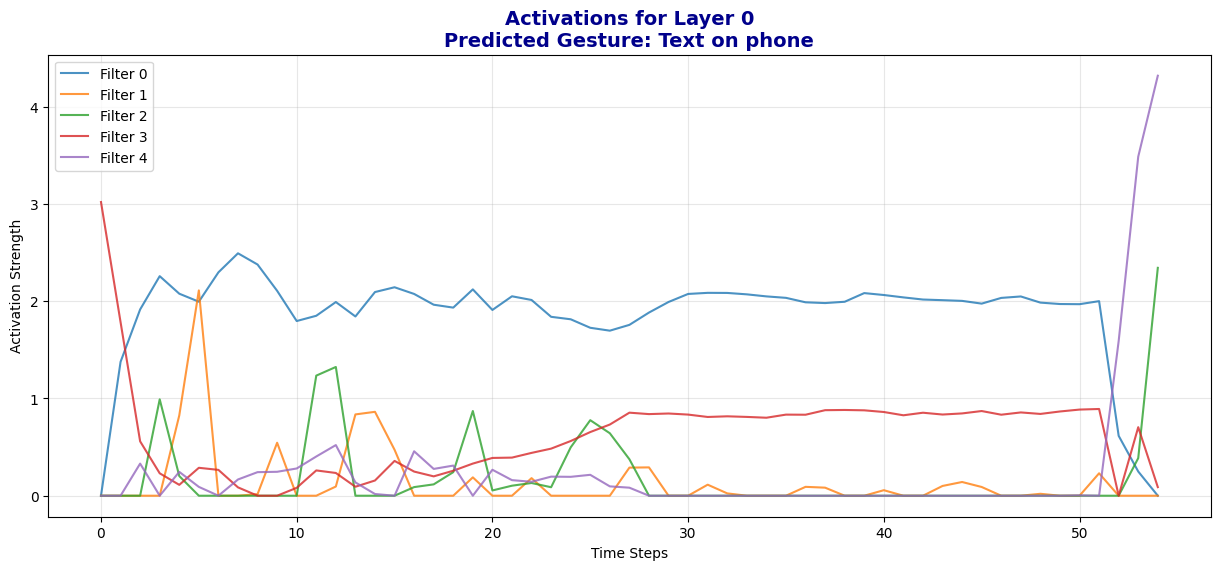

In [ ]:
print(gesture)
for i, seq_id in enumerate(sample_seqs):
    input_sequence = torch.tensor(val_set[val_set["sequence_id"] == seq_id][[
        "acc_x", "acc_y", "acc_z"
    ]].to_numpy(), dtype=torch.float32).T.unsqueeze(0).to(device)
    print(f"\n📊 Visualization for Sequence {i+1}/10 (ID: {seq_id})")
    visualize_activations(model, input_sequence, layer_idx=0, label_encoder=le)